---

# KDDCUP99_Rev

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

from model_ganomaly import GANomaly

In [2]:
def _encode_text_dummy(df, name):
    
    names = []
    dummies = pd.get_dummies(df.loc[:,name])
    i = 0
    
    tmpL = []
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df.loc[:, dummy_name] = dummies[x]
        names.append(dummy_name)
        _x = [i, x]
        tmpL.append(_x)
        i += 1
    
    df.drop(name, axis=1, inplace=True)
    return names, tmpL


def _to_xy(df, target):
    """Converts a Pandas dataframe to the x,y inputs"""
    y = df[target]
    x = df.drop(columns=target)
    return x, y


def get_KDDCUP99REV(PATH, seed, percAnomalies = 0.01, scale = True, show = False):
    
    columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
        'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
        'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
        'num_access_files', 'num_outbound_cmds', 'is_hot_login',
        'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
        'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
        'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate','dst_host_srv_rerror_rate', 'label']
    
    df = pd.read_csv(PATH, header=None, names=columns)
    discreteCol = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_hot_login', 'is_guest_login']
    
    names = []
    oneHot = dict()
    for name in discreteCol:
        n, t = _encode_text_dummy(df, name)
        names.extend(n)
        oneHot[name] = t
        
    # Delete nepture, smurf
    df_neptune = df[df['label'] == 'neptune.']
    df_smurf = df[df['label'] == 'smurf.']
    df = df.loc[~df.index.isin(df_neptune.index)]
    df = df.loc[~df.index.isin(df_smurf.index)]

    labels = df['label'].copy()
    labels[labels != 'normal.'] = 0 # anomalous
    labels[labels == 'normal.'] = 1 # normal

    df['label'] = labels
    normal = df[df['label'] == 1] 
    abnormal = df[df['label'] == 0]
    
    normal = shuffle(normal, random_state = seed)
    abnormal = shuffle(abnormal, random_state = seed)

    abnormal_1 = abnormal[:int(len(abnormal)*.5)+1]
    abnormal_2 = abnormal[int(len(abnormal)*.5)+1:]

    test_size_ab = int(len(abnormal_1)*(3/4))
    val_size_ab = int(len(abnormal_1)*(1/4))

    test_size_n = int(.15 * (len(normal) + len(abnormal_1)) - test_size_ab + 1)
    val_size_n = int(.05 * (len(normal) + len(abnormal_1)) - val_size_ab + 1)

    train_size = int(len(normal) - val_size_n - test_size_n)+1

    train_normal = normal[:train_size]
    val_normal = normal[train_size: train_size+val_size_n]
    test_normal = normal[train_size+val_size_n: ]

    val_abnormal = abnormal[:val_size_ab]
    test_abnormal = abnormal[val_size_ab:val_size_ab+test_size_ab]

    train_abnormal = abnormal_2[:int(len(train_normal)*percAnomalies)]
    
    train_set = pd.concat((train_normal, train_abnormal))
    val_set = pd.concat((val_normal, val_abnormal))
    test_set = pd.concat((test_normal, test_abnormal))
    
    train_set['label'].replace({0:1}, inplace = True)
    
    x_train, y_train = _to_xy(train_set, target='label')
    x_val, y_val = _to_xy(val_set, target='label')
    x_test, y_test = _to_xy(test_set, target='label')
    
    
    if show:
        print('{} normal records, {} anormal records'.format(len(normal), len(abnormal)))
        print(f'We use {len(abnormal_1)} anomalous records')
        print('-' * 89)
        print(f'There are {len(x_train)} records in training set')
        print(f'Training set is composed by {len(x_train[y_train == 1])} normal records and {len(x_train[y_train == 0])} abnormal records')
        print(f'There are {len(train_abnormal)} records anomalies labeled as normal')
        print('-' * 89)
        print(f'There are {len(x_val)} records in validation set')
        print(f'Validation set is composed by {len(x_val[y_val == 1])} normal records and {len(x_val[y_val == 0])} abnormal records')
        print('-' * 89)
        print(f'There are {len(x_test)} records in test set')
        print(f'Test set is composed by {len(x_test[y_test == 1])} normal records and {len(x_test[y_test == 0])} abnormal records')

    selected_columns = dict()
    
    for name in discreteCol:
        cols = [col for col in names if name in col]
        tmp = []
        
        for c in cols:
            tmp.append(x_train.columns.get_loc(c))

        selected_columns[name] = tmp
    
    x_train = x_train.to_numpy()
    x_val = x_val.to_numpy()
    x_test = x_test.to_numpy()
    
    index = np.arange(0, len(columns)-len(discreteCol)-1)

    if scale:
        scaler = MinMaxScaler()
        scaler.fit(x_train[:, index])
        x_train[:, index] = scaler.transform(x_train[:, index])
        x_val[:, index] = scaler.transform(x_val[:, index])
        x_test[:, index] = scaler.transform(x_test[:, index])
        
        
    dataset = {}
    dataset['x_train'] = x_train.astype(np.float32)
    dataset['y_train'] = y_train.astype(np.float32)
    
    dataset['x_val'] = x_val.astype(np.float32)
    dataset['y_val'] = y_val.astype(np.float32)
    
    dataset['x_test'] = x_test.astype(np.float32)
    dataset['y_test'] = y_test.astype(np.float32)
    
    dataset['selectedColumns'] = selected_columns
    dataset['discreteCol'] = discreteCol
    dataset['oneHot'] = oneHot
    dataset['index'] = index
    dataset['scaler'] = scaler
    
    return dataset

In [3]:
def meanAUC_PRAUC(auc_list, pr_list, name, SPACE_AUC, SPACE_AUPRC):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    AU_NAME = f'{name}.csv'
    
    AUC_Frame.to_csv(os.path.join(SPACE_AUC, AU_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(SPACE_AUPRC, AU_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

In [4]:
batch_size = 1024

WORK_SPACE = '../Dataset'
FILE = 'kddcup.data_10_percent_corrected'

SPACE_MODELS = './models'
SPACE_AUC = './auc'
SPACE_AUPRC = './auprc'

for n in (SPACE_MODELS, SPACE_AUC, SPACE_AUPRC):
    if not os.path.exists(n):
        os.mkdir(n)

DATASET = 'KDDCUP99_95P'

PATH = os.path.join(WORK_SPACE, FILE)

In [5]:
dataset = get_KDDCUP99REV(PATH, seed, percAnomalies = 0.05, show=True)

97278 normal records, 8752 anormal records
We use 4377 anomalous records
-----------------------------------------------------------------------------------------
There are 85389 records in training set
Training set is composed by 85389 normal records and 0 abnormal records
There are 4066 records anomalies labeled as normal
-----------------------------------------------------------------------------------------
There are 5083 records in validation set
Validation set is composed by 3989 normal records and 1094 abnormal records
-----------------------------------------------------------------------------------------
There are 15248 records in test set
Test set is composed by 11966 normal records and 3282 abnormal records


In [6]:
args = {}
nc = dataset['x_train'].shape[1]
nz = 100
manualseed = -1
print_freq = 100
args['w_adv'] = 1
args['w_con'] = 50
args['w_enc'] = 1
isTrain = True 

#### Mean AUC and standard deviation after seven runs

Iteration: 1
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.022 | g_loss: 0.1866
[INFO] Training phase... Elapsed time: 624 seconds



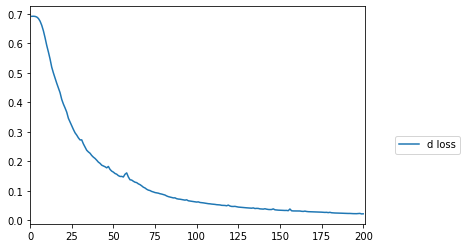

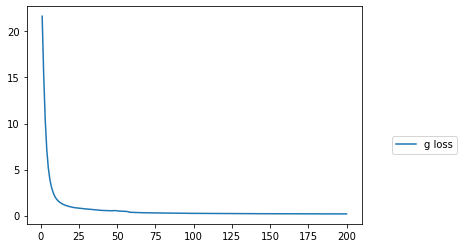

PR AUC: 0.51


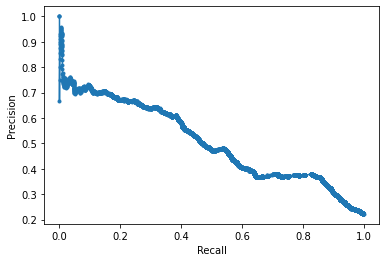

AUC: 0.78
Iteration: 2
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.029 | g_loss: 0.1260
[INFO] Training phase... Elapsed time: 667 seconds



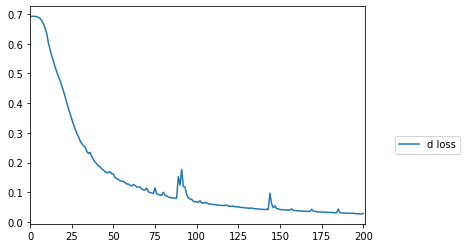

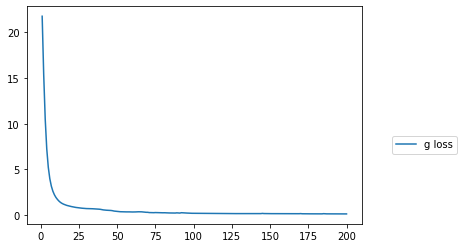

PR AUC: 0.59


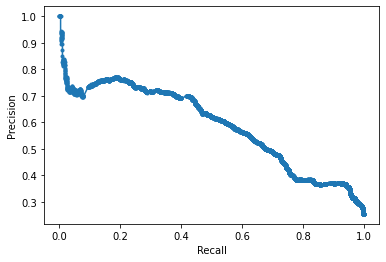

AUC: 0.84
Iteration: 3
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.019 | g_loss: 0.1655
[INFO] Training phase... Elapsed time: 662 seconds



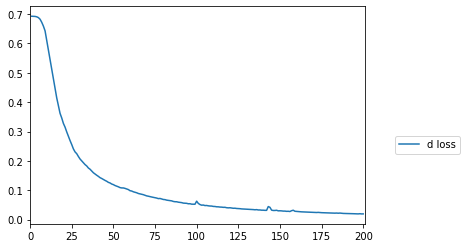

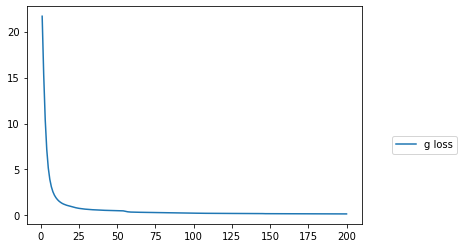

PR AUC: 0.62


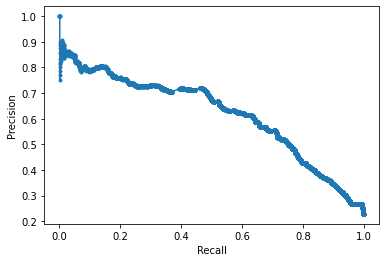

AUC: 0.84
Iteration: 4
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.019 | g_loss: 0.1410
[INFO] Training phase... Elapsed time: 661 seconds



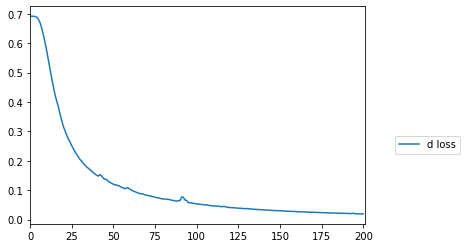

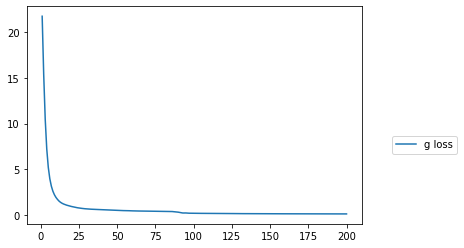

PR AUC: 0.53


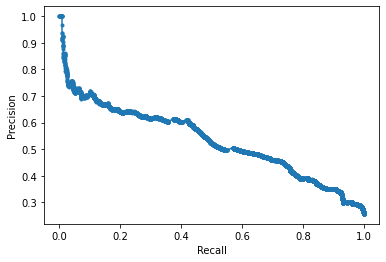

AUC: 0.82
Iteration: 5
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.018 | g_loss: 0.1306
[INFO] Training phase... Elapsed time: 666 seconds



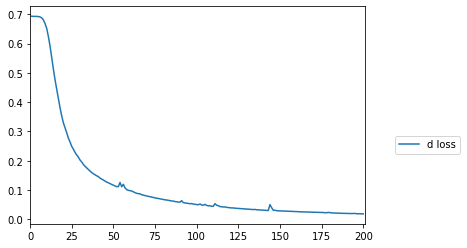

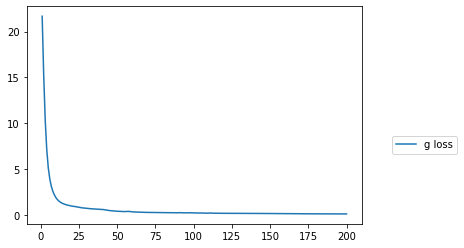

PR AUC: 0.52


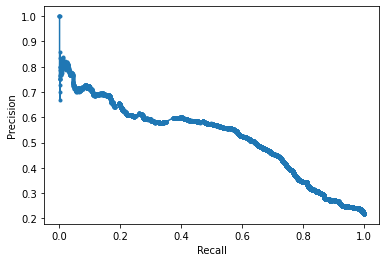

AUC: 0.78
Iteration: 6
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.018 | g_loss: 0.1605
[INFO] Training phase... Elapsed time: 665 seconds



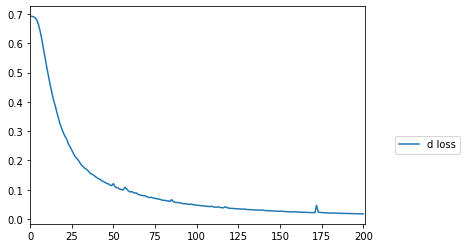

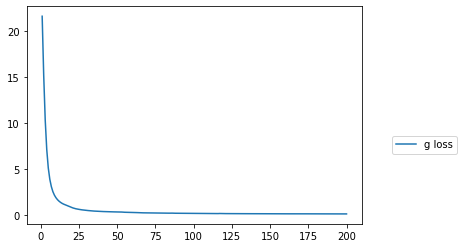

PR AUC: 0.56


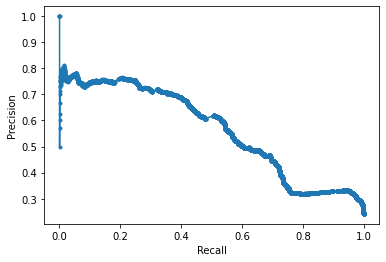

AUC: 0.81
Iteration: 7
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.020 | g_loss: 0.1690
[INFO] Training phase... Elapsed time: 663 seconds



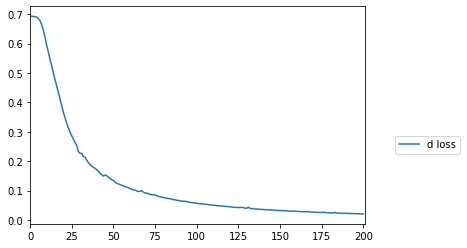

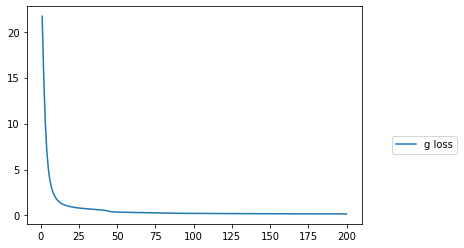

PR AUC: 0.53


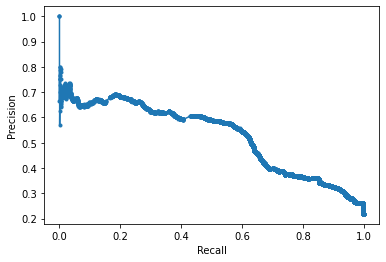

AUC: 0.80
Iteration: 8
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.018 | g_loss: 0.1363
[INFO] Training phase... Elapsed time: 674 seconds



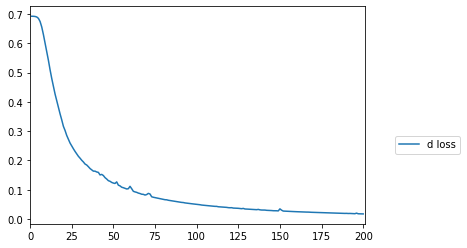

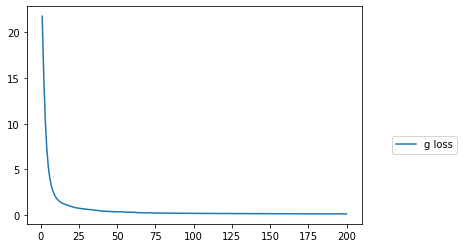

PR AUC: 0.56


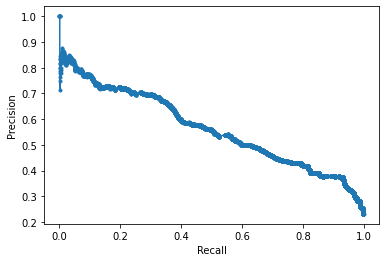

AUC: 0.83
Iteration: 9
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.018 | g_loss: 0.1367
[INFO] Training phase... Elapsed time: 654 seconds



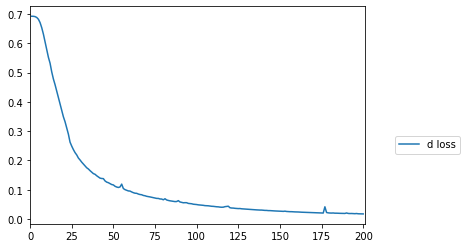

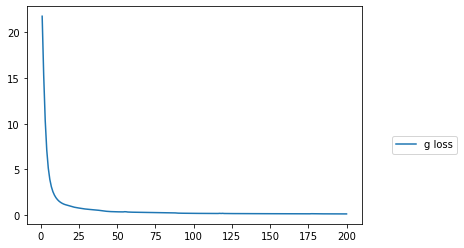

PR AUC: 0.50


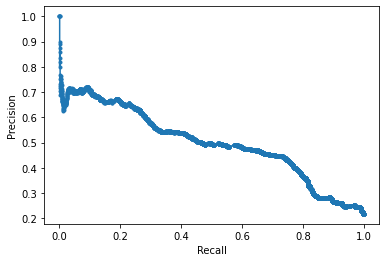

AUC: 0.78
Iteration: 10
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.020 | g_loss: 0.1618
[INFO] Training phase... Elapsed time: 758 seconds



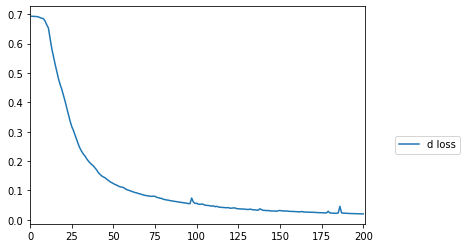

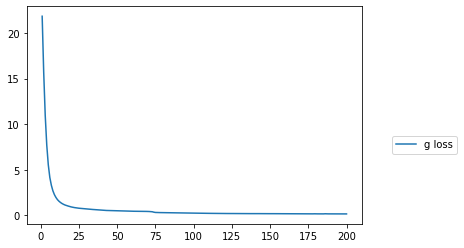

PR AUC: 0.48


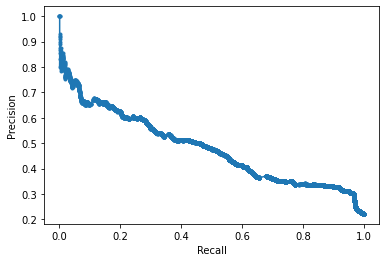

AUC: 0.77
Iteration: 11
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.019 | g_loss: 0.1361
[INFO] Training phase... Elapsed time: 764 seconds



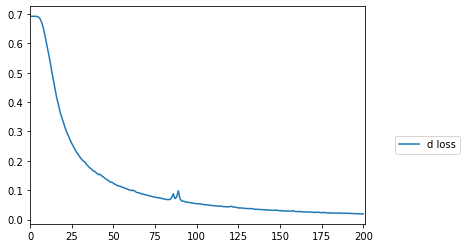

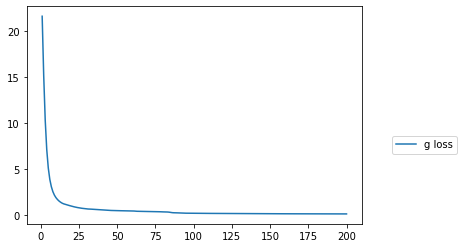

PR AUC: 0.59


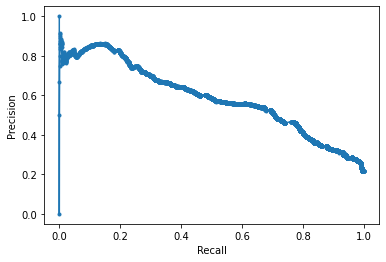

AUC: 0.83
Iteration: 12
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.017 | g_loss: 0.1425
[INFO] Training phase... Elapsed time: 753 seconds



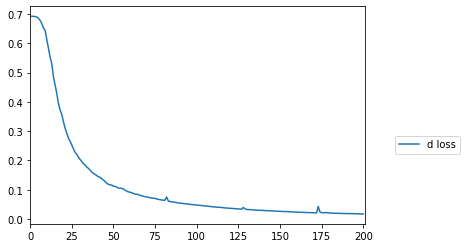

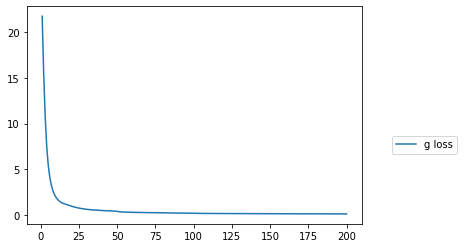

PR AUC: 0.51


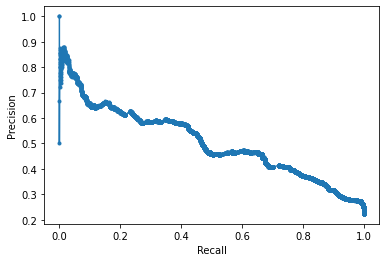

AUC: 0.79
Iteration: 13
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.016 | g_loss: 0.1820
[INFO] Training phase... Elapsed time: 747 seconds



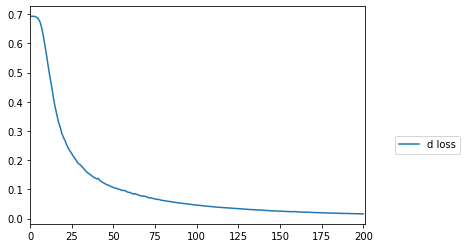

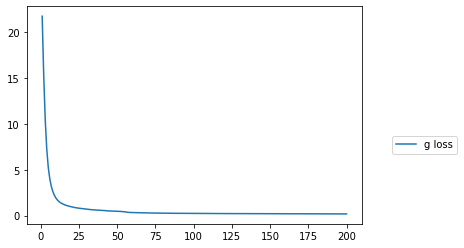

PR AUC: 0.58


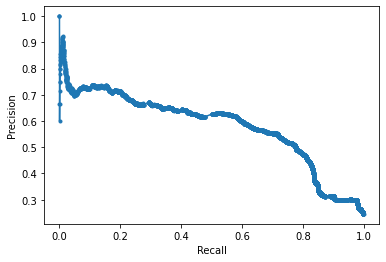

AUC: 0.84
Iteration: 14
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.019 | g_loss: 0.1400
[INFO] Training phase... Elapsed time: 733 seconds



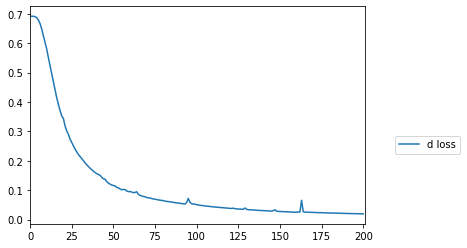

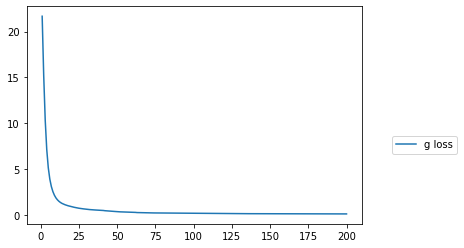

PR AUC: 0.50


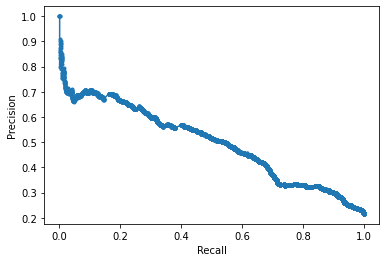

AUC: 0.77
Iteration: 15
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.020 | g_loss: 0.1310
[INFO] Training phase... Elapsed time: 732 seconds



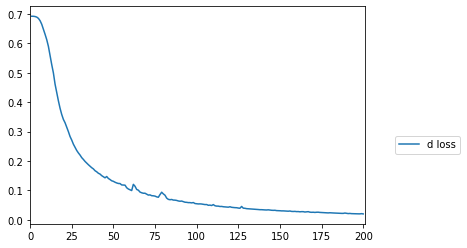

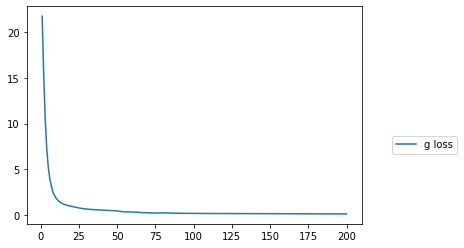

PR AUC: 0.52


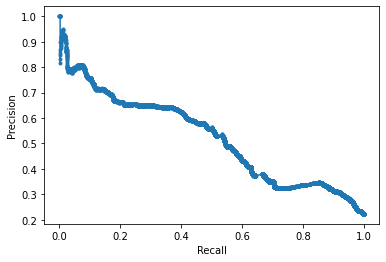

AUC: 0.78
Iteration: 17
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.018 | g_loss: 0.1625
[INFO] Training phase... Elapsed time: 783 seconds



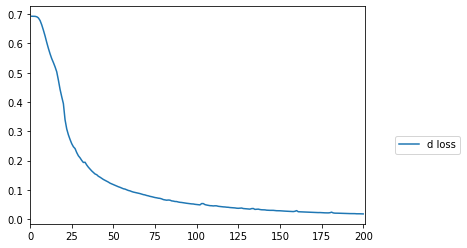

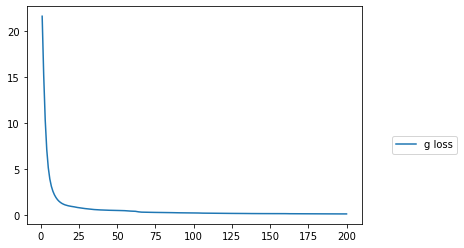

PR AUC: 0.54


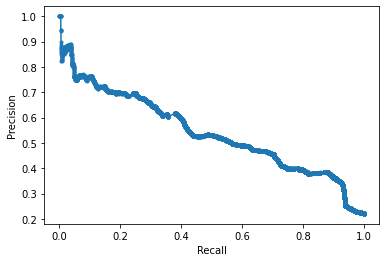

AUC: 0.80
Iteration: 18
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.024 | g_loss: 0.1200
[INFO] Training phase... Elapsed time: 800 seconds



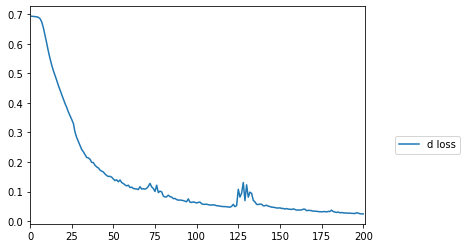

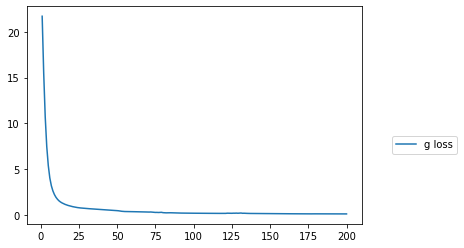

PR AUC: 0.59


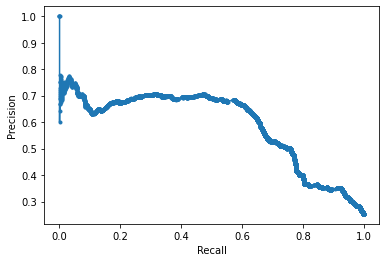

AUC: 0.84
Iteration: 19
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.019 | g_loss: 0.1405
[INFO] Training phase... Elapsed time: 797 seconds



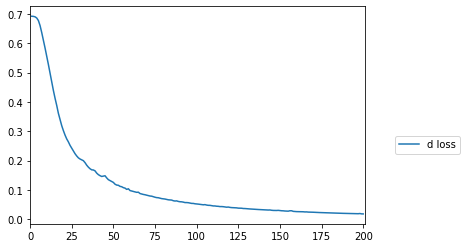

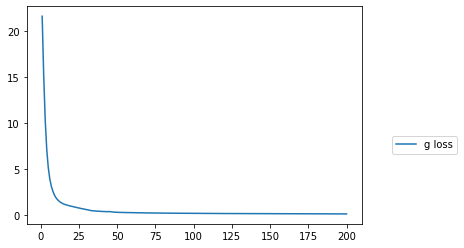

PR AUC: 0.58


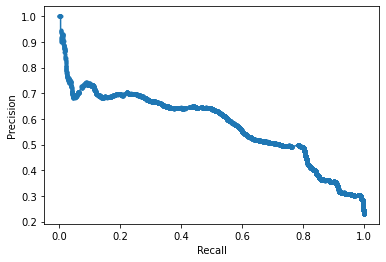

AUC: 0.84
Iteration: 20
[INFO] Starting training phase...

Epoch [200/200] | d_loss: 0.022 | g_loss: 0.1266
[INFO] Training phase... Elapsed time: 718 seconds



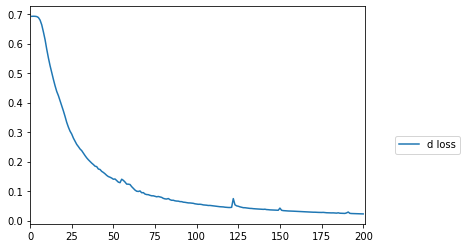

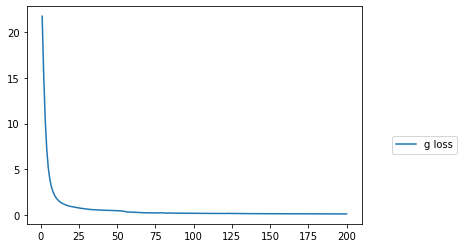

PR AUC: 0.51


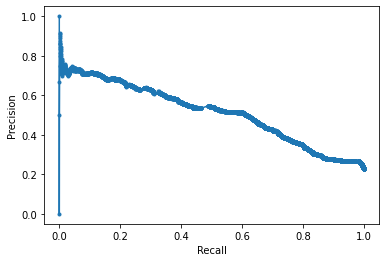

AUC: 0.78


In [7]:
n_runs = 20
auc_list = []
n_epochs = 200
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_KDDCUP99REV(PATH, seed*(i+1), percAnomalies = 0.05, show=False)
    
    # Convert Normal Label in 0 and Anomalous in 1
    dataset['y_test'].replace({1:0, 0:1}, inplace = True)
    
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_train']).to(device), 
                                              torch.tensor(dataset['y_train'].to_numpy()).to(device))
    
    train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']).to(device), 
                                              torch.tensor(dataset['y_val'].to_numpy()).to(device))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']).to(device), 
                                              torch.tensor(dataset['y_test'].to_numpy()).to(device))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    ganomaly = GANomaly(nc, nz, device)
    
    _auc, pr_auc = ganomaly.train_and_test(train_loader, test_loader, args, n_epochs, batch_size)
    
    # Save models
    NAME_D = f'D_GANomaly_{DATASET}_{i}.ckpt'
    NAME_G = f'G_GANomaly_{DATASET}_{i}.ckpt'
    
    torch.save(ganomaly.D.state_dict(), os.path.join(SPACE_MODELS, NAME_D))
    torch.save(ganomaly.G.state_dict(), os.path.join(SPACE_MODELS, NAME_G))
    
    print(f'AUC: {_auc:.2f}')
    auc_list.append(_auc)
    pr_list.append(pr_auc)

In [8]:
meanAUC_PRAUC(auc_list, pr_list, f'GANomaly_{DATASET}', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.7766271778774372, 0.8392133770647954, 0.8432530067162669, 0.8167616239104439, 0.7823095510405625, 0.8107860678381555, 0.8038217133187542, 0.8304736795896317, 0.7758199572768792, 0.7725789162122256, 0.8253552137312066, 0.7936830821595577, 0.8352187026353257, 0.7689688629259643, 0.8084601093510629, 0.7780290652888853, 0.8038735690591146, 0.8424189861320461, 0.8403852684169234, 0.7825277194586368]
**************
PR AUC:
[0.506421828832145, 0.5882852386946434, 0.61860549689993, 0.5340180631257616, 0.5214321627541811, 0.5645655751839602, 0.527556149539602, 0.564982386486671, 0.49971018640767606, 0.4812540318631533, 0.590343378757423, 0.5060824710682335, 0.5803404175871045, 0.4983874095808539, 0.5698531959697508, 0.5228196787886545, 0.5423210581437538, 0.5891504431095276, 0.5773353136076723, 0.5143863429341444]
**************
AUC
0.81 +/- 0.01
95% confidence level, average auc would be between 0.80 and 0.82
**************
PR AUC
0.54 +/- 0.02
95% confidence level, average auc would b

---